In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import sys

import os
import datetime
from sklearn.model_selection import train_test_split
import tensorflow as tf

sys.path.append("Mean-Variance-Hedging/")

from numpy.random import default_rng
from scipy.stats import norm
from scipy.special import comb
!rm -rf Mean-Variance-Hedging
!git clone https://github.com/chrischia06/Mean-Variance-Hedging


from mean_variance_hedge.dynamic_programming import *
from mean_variance_hedge.black_scholes import *
from mean_variance_hedge.utils import *

plt.style.use("fivethirtyeight")

Cloning into 'Mean-Variance-Hedging'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 75 (delta 22), reused 67 (delta 18), pack-reused 0
Unpacking objects: 100% (75/75), done.


+ Assume that price paths evolve with iid log-returns from a  finite state space
+ We use the same set of parameters as Cerny (2004)

In [ ]:
# discretised state space for log-returns
log_ret_space = np.linspace(0.06, -0.06, 7) #log-returns
scale_factor = 100 # scale so our "tree/lattice" has integer indices
log_ret_space2 = [round(x * scale_factor) for x in log_ret_space]
p_probs = np.array([0.013, 0.067, 0.273, 0.384, 0.199, 0.050, 0.014]) # physical probabilities
ret_space = np.exp(log_ret_space) # returns
N_STATES = len(log_ret_space)

# rf = 1.00075 # risk free return
rf = 1.00
r = rf - 1

print(f"Log Rets: {log_ret_space}")
print(f"P-probalities: {p_probs}")

excess_returns = np.dot(p_probs, (ret_space - rf))
var_rets = np.dot(p_probs, (ret_space - rf) ** 2)

print(f"Excess Returns: {np.round(ret_space - rf, 3)}") # excess returns
print(f"Mean Excess Return under P: {np.round(excess_returns, 3)}")
print(f"Variance Returns under P: {var_rets}")

# variance optimal measure
a, b, m, q_probs = calc_variance_optimal_measure(ret_space, rf, p_probs)
print(a, b)
print(np.round(q_probs, 3))

Log Rets: [ 0.06  0.04  0.02  0.   -0.02 -0.04 -0.06]
P-probalities: [0.013 0.067 0.273 0.384 0.199 0.05  0.014]
Excess Returns: [ 0.062  0.041  0.02   0.    -0.02  -0.039 -0.058]
Mean Excess Return under P: 0.002
Variance Returns under P: 0.00047508734571246594
4.918830695478636 0.9885053113595005
[0.009 0.054 0.248 0.389 0.221 0.06  0.018]


We calculate Mean-Value Process : $H_{t}$, which corresponds to do the ideal value of the mean-variance optimal portfolio to replicate the liability with payoff $H_{T}$, and the dynamic hedge quantities $\theta^{D}_{t}$. These can be calculated iterarively, in reverse, for each node in the lattice via dynamic programming

In [ ]:
##################
### PARAMETERS ###
##################

S0 = 100
K_strike = 100
# T = 6
T = 30
dt = 1/250
CALL = 1

attainable_nodes = possible_nodes(log_ret_space, T, scale_factor)
Hts = calc_mean_value_process(attainable_nodes, S0, K_strike, rf, log_ret_space, T, scale_factor, q_probs)
dynamic_delta = calc_dynamic_deltas(attainable_nodes, Hts, S0, rf, log_ret_space, T, scale_factor, q_probs)    

We compare the Dynamic Programming approach with the Black-Scholes delta. The Black-Scholes delta is only a perfect hedge in a continuous time setting with transaction costs

In [ ]:
# terminal states
BS_prices = {}

bs_rf = np.log(rf)
sigma = np.sqrt(np.sum(p_probs * (log_ret_space) ** 2) - np.sum(p_probs * log_ret_space) ** 2)    

# terminal payoffs H_{T}
BS_prices[T] = {}
for x in attainable_nodes[T]:
    St = S0 * np.exp(x / scale_factor)
    BS_prices[T][x] = np.maximum(St - K_strike , 0)
        
for t in range(T - 1, -1, -1):
  BS_prices[t] = {}
  for x in attainable_nodes[t]:
        St = S0 * np.exp(x / scale_factor)
        BS_prices[t][x] = BlackScholes(St = St, K = K_strike, r = bs_rf, sigma = sigma, 
                                       tau = (T - t), flag = 1)


bs_delta = {}
for t in range(T - 1, -1, -1):
  bs_delta[t] = {}
  for x in attainable_nodes[t]:
    St = S0 * np.exp(x / scale_factor)
    bs_delta[t][x] = delta(St = St, K=K_strike, r =bs_rf, sigma = sigma, tau = (T - t), flag = 1)

## Sample paths

+ We generate `N_SAMPLES` paths by simulation from the lattice

CPU times: user 640 ms, sys: 15.4 ms, total: 656 ms
Wall time: 661 ms


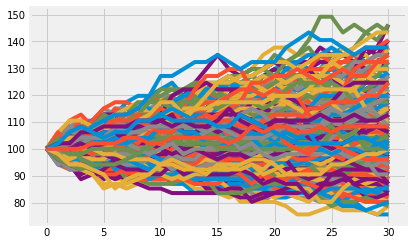

In [ ]:
%%time
N_SAMPLES = 10 ** 5

rng = default_rng(seed = 2021)
# sample paths under P
sample_log_rets = rng.choice(log_ret_space2,(N_SAMPLES, T),replace=True, p=p_probs)
sample_paths = S0 * np.exp(np.cumsum(sample_log_rets / scale_factor,axis=1)) # 0.. T
sample_log_rets = np.hstack([np.zeros(N_SAMPLES).reshape(-1, 1),  sample_log_rets])
sample_paths = np.hstack([S0 + np.zeros(N_SAMPLES).reshape(-1, 1),  sample_paths]) # 0.. T

# plot 500 paths
plt.plot(np.arange(T + 1),sample_paths[:500,:].T);

We calculate the portfolio value process $V_{t}$:

$$ V_{t + 1} = \text{rf} \cdot V_{t} + \delta_{\text{strat}}(S_{t + 1} - (\text{rf}) S_{t}) $$

and evaluate the Mean-Squared Hedging Error of the strategies at time $T$
$$ \mathbb{E}[|V_{T} - H_{T}|^{2}]$$

In [ ]:
# %%time
bs_deltas = np.zeros((N_SAMPLES, T))
deltas = np.zeros((N_SAMPLES, T ))
local_deltas = np.zeros((N_SAMPLES, T ))

bs_vals = np.zeros((N_SAMPLES, T + 1))
delta_vals = np.zeros((N_SAMPLES, T + 1)) 
local_vals = np.zeros((N_SAMPLES, T + 1))

bs_vals[:,0] = Hts[0][0]
delta_vals[:,0] = Hts[0][0]
local_vals[:,0] = Hts[0][0]

# black-scholes delta
bs_deltas[:,0] = bs_delta[0][0]
# dynamic programming delta
deltas[:, 0] = dynamic_delta[0][0]
# dynamic delta adjusted for current portfolio value V_t
local_deltas[:, 0] = dynamic_delta[0][0]

# calculate the hedging portfolio value
# in the case of the dynamic programming approach, hedge is path-dependent
for i in range(N_SAMPLES):
  for t in range(1, T):
    current_node = int(sum(sample_log_rets[i, :t + 1]))
    delta_vals[i, t] = (rf * delta_vals[i, t - 1] + 
                        deltas[i, t - 1] * 
                        (sample_paths[i, t] - rf * sample_paths[i, t - 1]))
    local_vals[i, t] = (rf * local_vals[i, t - 1] + 
                        local_deltas[i, t - 1] * 
                        (sample_paths[i, t] - rf * sample_paths[i, t - 1]))
    bs_deltas[i, t] = bs_delta[t][current_node]
    deltas[i, t] = dynamic_delta[t][current_node]
    local_deltas[i, t] = (dynamic_delta[t][current_node] + 
                         rf * a * (Hts[t][current_node] - local_vals[i, t]) / sample_paths[i, t])
    
  local_vals[i, T] = (rf * local_vals[i, T - 1] + 
                      local_deltas[i, T - 1] * 
                      (sample_paths[i, T] - rf * sample_paths[i, T - 1]))
  

# tis = np.arange(T + 1) #0, 1 .. T
# tis = np.tile(tis, N_SAMPLES).reshape(N_SAMPLES, T + 1) # [[0, 1.. T], [0, 1.. T]...]
# for i in range(N_SAMPLES):
#   bs_deltas[i, :] = delta(sample_paths[i, :-1], K_strike, r, sigma, (T - tis[i,:-1]), CALL) # BS deltas

for t in range(1, T + 1):
  bs_vals[:, t] = (rf * bs_vals[:, t - 1] + 
                     bs_deltas[:, t - 1] * (sample_paths[:, t] - rf * sample_paths[:, t - 1]))
  delta_vals[:, t] = (rf * delta_vals[:, t - 1] + 
                      deltas[:, t - 1] * (sample_paths[:, t] - rf * sample_paths[:, t - 1]))
  
bs_terminal_error = bs_vals[:, T] - np.maximum(sample_paths[:, T] - K_strike, 0)  
delta_terminal_error = delta_vals[:, T] - np.maximum(sample_paths[:, T] - K_strike, 0)
local_terminal_error = local_vals[:, T] - np.maximum(sample_paths[:, T] - K_strike, 0)

# Deep Hedging



+ We create simulate another set of  paths, from the same lattice structure to use as training data for the Deep-Hedging model

+

In [ ]:
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def deep_hedger(T, n_feats):
    """
    Feed-Forward Neural Network
    """
    input_layer = Input(shape = (None, n_feats))
    # batch_norm = BatchNormalization()(input_layer)
    layer_1 = GRU(64, activation='tanh', 
                      kernel_initializer=initializers.RandomNormal(0,0.1),
                      bias_initializer=initializers.RandomNormal(0,0.1),
                  return_sequences=True
                  )(input_layer)
    # layer_2 = Dense(16, activation='relu',
    #                 kernel_initializer=initializers.RandomNormal())(batch_norm1)
    # batch_norm2 = BatchNormalization()(layer_2)
    # layer_3 = Dense(8, activation='relu', 
    #                 kernel_initializer = initializers.RandomNormal())(batch_norm2)
    # batch_norm3 = BatchNormalization()(layer_3)
    output_layer = Dense(1, activation='linear',
                         kernel_initializer=initializers.RandomNormal(),
                         bias_initializer=initializers.RandomNormal(0,0.1)
                         )(layer_1)
    model = Model(input_layer, output_layer)
    return model

In [ ]:
def MSHE_Loss(init_price, strike, T):
    def lossFunction(y_true,y_pred):
      # for simplcity ignore rf for now, although this could be incorporated
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)
      # print(tf.shape(price_changes))     
      # print(tf.shape(y_true)Z)
      option_val = tf.math.maximum(y_true[:,-1] - strike, 0)

      # val = (tf.math.reduce_sum(deltas * price_changes,axis=1))
      return tf.math.reduce_mean(tf.math.square(-option_val + val + init_price))
    return lossFunction

def cvarLoss(init_price, strike, T, batch_size, proportion = 0.01):
    num = int(batch_size * proportion)
    def lossFunction(y_true,y_pred):
      price_changes = tf.experimental.numpy.diff(y_true, n=1, axis=1)
      val = tf.reduce_sum(tf.math.multiply(price_changes, y_pred),axis=1)      
      option_val = tf.math.maximum(y_true[:,-1,:] - strike, 0)
      # top k worse - net value
      error = tf.reshape(-(-option_val + val + init_price), [-1])
      CVaR, idx = tf.math.top_k(error, tf.constant(num, dtype=tf.int32))
      # return tf.math.reduce_mean(CVaR)
      return tf.math.reduce_mean(CVaR)
    return lossFunction

Define training and test data

In [ ]:
X_true = np.log(sample_paths[:,:-1] / K_strike)
X_true = X_true.reshape((-1, T, 1))
y_true = sample_paths.reshape((-1, T + 1, 1))


N_TRAIN_PATHS = 10 ** 5
rng2 = default_rng(seed = 42)
training_log_rets = rng.choice(log_ret_space2,(N_TRAIN_PATHS, T),replace=True, p=p_probs)
train_paths = S0 * np.exp(np.cumsum(training_log_rets / scale_factor,axis=1))
train_paths = np.hstack([S0 + np.zeros(N_TRAIN_PATHS).reshape(-1, 1),  train_paths])
X = np.log(train_paths / K_strike)

n_feats = 1
X2 = X[:, :-1].reshape((-1, T, n_feats))
y2 = train_paths.reshape((-1, T + 1, n_feats))

X_train, X_val, y_train, y_val = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [ ]:
tf.random.set_seed(2021) # set random seed for reproducibility

######################
### DNN PARAMETERS ###
######################

lr = 0.005
BATCH_SIZE = 256
EPOCHS = 50

# logging and early stopping
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_callback =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


# Model trained on MSHE
model = deep_hedger(T, n_feats)
model.summary()
print("Check Model", model.predict(np.zeros((1, T, 1))).reshape(-1))

mshe_loss = MSHE_Loss(init_price=Hts[0][0], strike=K_strike, T = T)
model.compile(optimizer=Adam(learning_rate=lr), loss=mshe_loss)
model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
          batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
          validation_data=(X_val, y_val), shuffle=False)

# Model trained on CVaR
# cvar_loss = cvarLoss(init_price = Hts[0][0], strike = K_strike, T = T, batch_size = BATCH_SIZE, proportion = 0.01)

# cvar_model = deep_hedger(T, n_feats)
# cvar_model.compile(optimizer=Adam(learning_rate=lr), loss=cvar_loss)
# cvar_model.fit(X_train, y_train, epochs=EPOCHS, verbose=1, 
#           batch_size=BATCH_SIZE, callbacks=[tensorboard_callback,early_stopping_callback],
#           validation_data=(X_val, y_val), shuffle=False)


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru_6 (GRU)                  (None, None, 64)          12864     
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)           65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Check Model [-0.06002112 -0.06295123 -0.06532431 -0.06741942 -0.06917582 -0.07055762
 -0.07159068 -0.07233414 -0.07285407 -0.0732097  -0.07344861 -0.07360668
 -0.07370988 -0.07377638 -0.07381875 -0.07384543 -0.07386204 -0.07387224
 -0.07387842 -0.07388212 -0.0738843  -0.07388556 -0.07388628 -0.07388668
 -0.0738869  -0.073887   -0.07388704 -0.07388707 -0.07388708 -0.07388708]
Epoch 1

In [ ]:
%%time
deep_hedge_deltas = np.zeros((N_SAMPLES, T))
# deep_cvar_hedge_deltas = np.zeros((N_SAMPLES, T))

for i in range(T):
  temp= model.predict(X_true[:,:(i + 1),:], batch_size=512)
  deep_hedge_deltas[:,i] =  temp.reshape(-1, i + 1)[:,i]
  # temp2 = cvar_model.predict(X_true[:,:(i + 1),:], batch_size=512)
  # deep_cvar_hedge_deltas[:, i] = temp2.reshape(-1, i + 1)[:,i]

CPU times: user 2min 24s, sys: 8.91 s, total: 2min 33s
Wall time: 1min 31s


In [ ]:
%%time
# deep_hedge_deltas2 = model.predict(X2, batch_size=128)

## MSHE Deep Hedger
deep_vals = np.zeros((N_SAMPLES, T + 1))
deep_vals[:,0] = Hts[0][0]

## CVar Deep Hedger
# deep_cvar_vals = np.zeros((N_SAMPLES, T + 1))
# deep_cvar_vals[:,0] = Hts[0][0]


for t in range(1, T + 1):
    deep_vals[:, t] = rf * deep_vals[:, t - 1] + deep_hedge_deltas[:, t - 1] * (sample_paths[:, t] - rf * sample_paths[:, t - 1]) 
    # deep_cvar_vals[:, t] = rf * deep_cvar_vals[:, t - 1] + deep_cvar_hedge_deltas[:, t - 1] * (sample_paths[:, t] - rf * sample_paths[:, t - 1])
  

deep_terminal_error = deep_vals[:, T] - np.maximum(sample_paths[:, T] - K_strike, 0)
# deep_cvar_terminal_error = deep_cvar_vals[:, T] - np.maximum(sample_paths[:, T] - K_strike, 0)
  

CPU times: user 182 ms, sys: 1.78 ms, total: 184 ms
Wall time: 186 ms


# Evaluation

+ Notes - very architecture dependent.  Random weight initialisation and the internal RNN state means that result will vary every time we recalibrate the model
+ Might depend on training / sample size as well

,MSHE,CVar 1%,CVaR 5%,CVar 10%,CVaR 50%
BS-delta,0.597286,2.657331,1.850045,1.497005,0.652096
Local Hedge,0.616136,2.703191,1.892651,1.540386,0.699768
Dynamic Hedge,0.548533,2.890243,1.877210,1.460282,0.608718
Deep-Hedger,0.572591,3.014344,1.891262,1.448645,0.524646


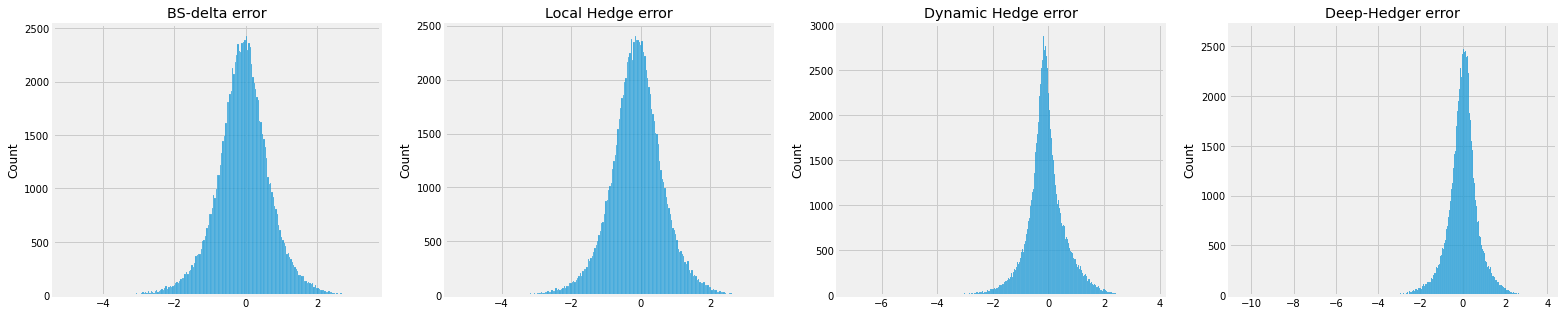

In [ ]:
hedging_errors = [bs_terminal_error, delta_terminal_error, local_terminal_error,
                  deep_terminal_error] #, deep_cvar_terminal_error]

hedging_errors2 = [diagnosis(error) for error in hedging_errors]
results = pd.concat(hedging_errors2)

titles = ["BS-delta", "Local Hedge", "Dynamic Hedge", ] + ["Deep-Hedger"]#, "Deep-CVaR-Hedger"]
results.index = titles
display(results)


plot_titles = [title +" error" for title in titles]
fig, ax = plt.subplots(ncols= len(titles), figsize=(len(titles) * 6, 5))
for i in range(len(titles)):
  sns.histplot(hedging_errors[i], ax=ax[i]).set_title(plot_titles[i]) 

In [ ]:
print(results.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &      MSHE &   CVar 1\% &   CVaR 5\% &  CVar 10\% &  CVaR 50\% \\
\midrule
BS-delta      &  0.597286 &  2.657331 &  1.850045 &  1.497005 &  0.652096 \\
Local Hedge   &  0.616136 &  2.703191 &  1.892651 &  1.540386 &  0.699768 \\
Dynamic Hedge &  0.548533 &  2.890243 &  1.877210 &  1.460282 &  0.608718 \\
Deep-Hedger   &  0.572591 &  3.014344 &  1.891262 &  1.448645 &  0.524646 \\
\bottomrule
\end{tabular}



What is the neural network doing?

43309


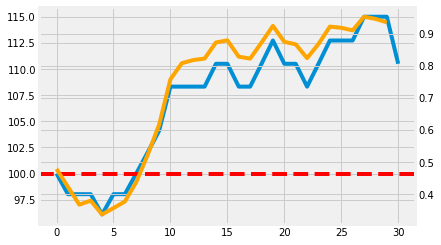

In [ ]:
i = np.random.randint(N_SAMPLES)
print(i)
fig, ax = plt.subplots()
plt.plot(np.arange(0, T + 1),  sample_paths[i,:].T)
ax2 = ax.twinx()
ax2.plot(np.arange(0, T), deep_hedge_deltas[i,:].T, c='orange')
ax.axhline(K_strike,linestyle="--", c='red')

Check that the Mean-Variance Loss Function for the Deep Neural Network is close the calculated value

In [ ]:
test_loss = customLoss()
test_loss(y_true, bs_deltas.reshape(-1, 6, 1))

<tf.Tensor: shape=(), dtype=float64, numpy=0.6068282727047436>

In [ ]:
test_loss(y_true, local_deltas.reshape(-1, 6, 1))

<tf.Tensor: shape=(), dtype=float64, numpy=0.606398617187597>

Implementation from Teichmann, J., website:

Return to later as quite difficult to understand

+ https://nbviewer.jupyter.org/url/people.math.ethz.ch/~jteichma/lecture_ml_web/deep_hedging_keras_bsanalysis.ipynb

+ https://nbviewer.jupyter.org/urls/people.math.ethz.ch/~jteichma/lecture_ml_web/lecture_3.ipynb

In [ ]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt

In [ ]:
T = 6
N = N

In [ ]:
#Definition of neural networks for heding strategies

m = 1 # dimension of price
d = 3 # number of layers in strategy
n = 8  # nodes in the first but last layers

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                      bias_initializer='random_normal',
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.1),#kernel_initializer='random_normal',
                          bias_initializer='random_normal',
                          name=str(i)+str(j))
        layers = layers + [layer]

In [ ]:
#Implementing the loss function
# Inputs is the training set below, containing the price S0, 
#the initial hedging being 0, and the increments of the log price process 
price = Input(shape=(m,))
hedge = Input(shape=(m,))
hedgeeval = Input(shape=(m,))
premium = Input(shape=(m,))

inputs = [price]+[hedge]+[hedgeeval]+[premium]
outputhelper=[]

premium = Dense(m, activation='linear', trainable=True,
                kernel_initializer=initializers.RandomNormal(0,1),#kernel_initializer='random_normal',
                bias_initializer=initializers.RandomNormal(0,1))(premium)

for j in range(N):
    strategy = price
    strategyeval=hedgeeval
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the hedging strategy at j , i.e. the neural network g_j
        strategyeval=layers[k+(j)*d](strategyeval)
    incr = Input(shape=(m,))
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, incr])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)# creating the price at time j+1
    priceincr=Subtract()([pricenew, price])
    hedgenew = Multiply()([strategy, priceincr])
    #mult = Lambda(lambda x : K.sum(x,axis=1))(mult) # this is only used for m > 1
    hedge = Add()([hedge,hedgenew]) # building up the discretized stochastic integral
    inputs = inputs + [incr]
    outputhelper = outputhelper + [strategyeval]
    price=pricenew
payoff= Lambda(lambda x : 0.5*(K.abs(x-K_strike)+x-K_strike))(price) 
outputs = Subtract()([payoff,hedge]) 
outputs = Subtract()([outputs,premium]) # payoff minus price minus hedge 
outputs= [outputs] + outputhelper +[premium]
outputs = Concatenate()(outputs)

model_hedge_strat = Model(inputs=inputs, outputs=outputs)

In [ ]:
initialprice = S0

# xtrain consists of the price S0, 
#the initial hedging being 0, and the increments of the log price process 
xtrain = ([initialprice*np.ones((N_SAMPLES,m))] +
          [np.zeros((N_SAMPLES,m))]+
          [np.ones((N_SAMPLES,m))] +
          [BS_prices[0][0]*np.ones((N_SAMPLES,m))]+
          [(sample_log_rets[:,i] / 100).reshape(-1, 1) for i in range(N)])

ytrain=np.zeros((N_SAMPLES,1+T))


In [ ]:
from keras import losses
def custom_loss(y_true,y_pred):
    #return losses.mean_squared_error(y_true[0], y_pred[0])
    z = y_pred[:,0]-y_true[:,0]
    z=K.mean(K.square(z))
    return z


In [ ]:
model_hedge_strat.compile(optimizer='adam',loss=custom_loss)
model_hedge_strat.fit(x=xtrain,y=ytrain, epochs=1,verbose=True)

3125/3125 [==============================] - 7s 2ms/step - loss: 3.9857


In [ ]:
pred = model_hedge_strat.predict(xtrain)